In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.1


In [3]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    'data/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache/data-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


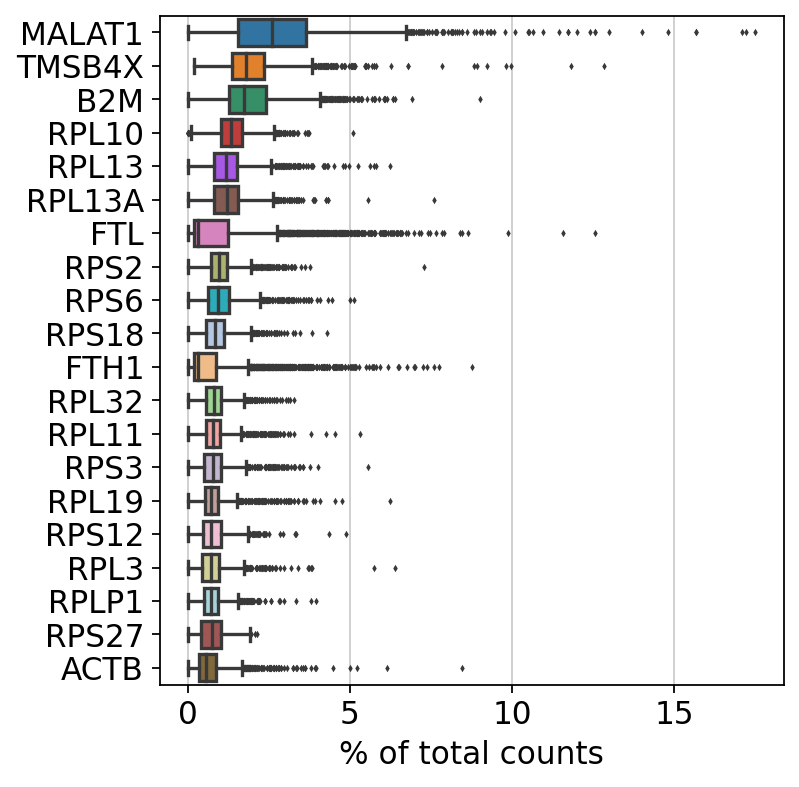

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py

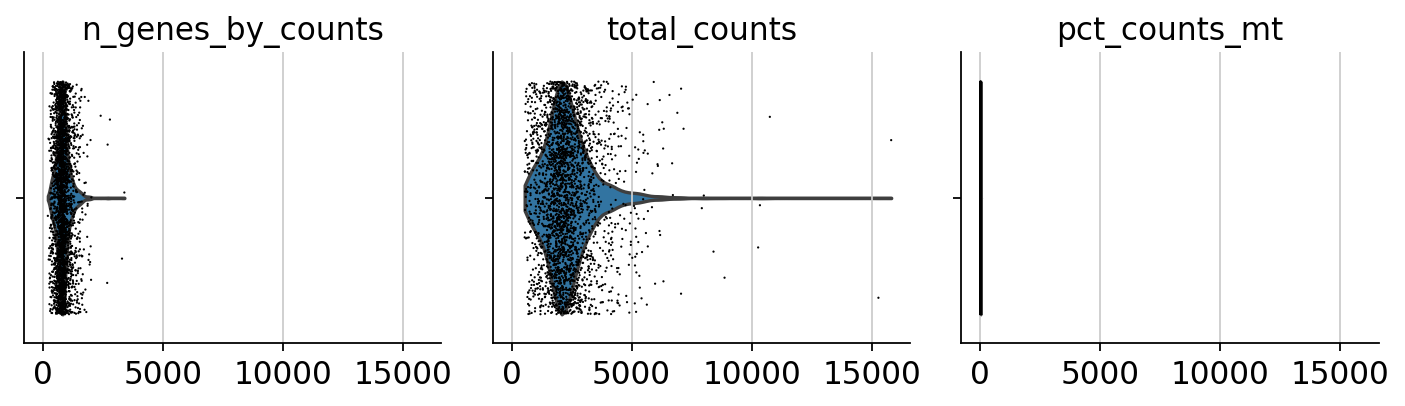

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

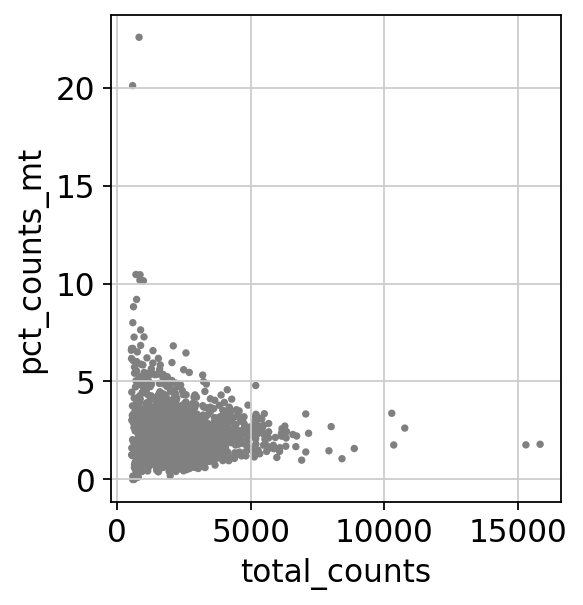

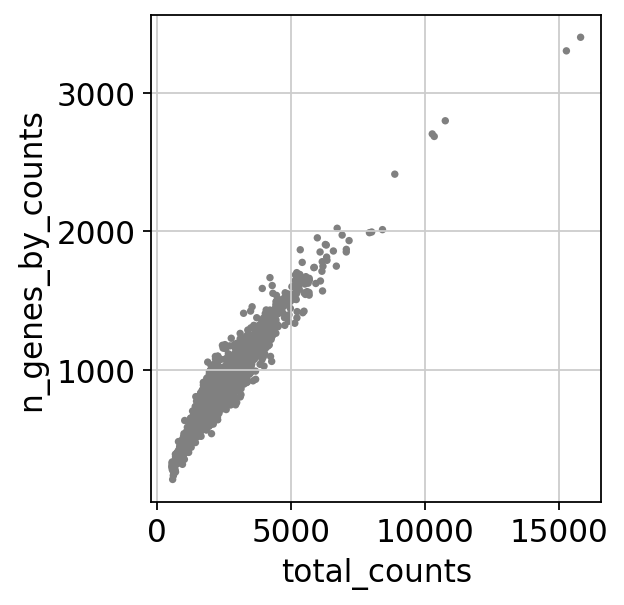

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
sc.pp.log1p(adata)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
mean_bin
(-0.00562, 0.281]    0.506465
(0.281, 0.562]       0.780289
(0.562, 0.843]       0.706225
(0.843, 1.124]       0.641588
(1.124, 1.406]       0.675595
(1.406, 1.687]       0.536114
(1.687, 1.968]       0.567208
(1.968, 2.249]       0.558539
(2.249, 2.53]        0.554934
(2.53, 2.811]        0.751645
(2.811, 3.092]       0.459635
(3.092, 3.373]       0.787758
(3.373, 3.654]       0.498541
(3.654, 3.936]       0.610389
(3.936, 4.217]       0.240446
(4.217, 4.498]       0.598663
(4.498, 4.779]       1.301101
(4.779, 5.06]        0.255172
(5.06, 5.341]        0.028877
(5.341, 5.622]            NaN
Name: dispersions, dtype: float64
mean_bin
(-0.00562, 0.281]    False
(0.281, 0.562]       False
(0.562, 0.843]       False
(0.843, 1.124]       False
(1.124, 1.406]       False
(1.406, 1.687]       False
(1.687, 1.968]       False
(1.968, 2.249]       False
(2.249, 2.53]        False
(2.53, 2.811]        False
(2.811, 3.092]       False
(3.092, 3.373]    

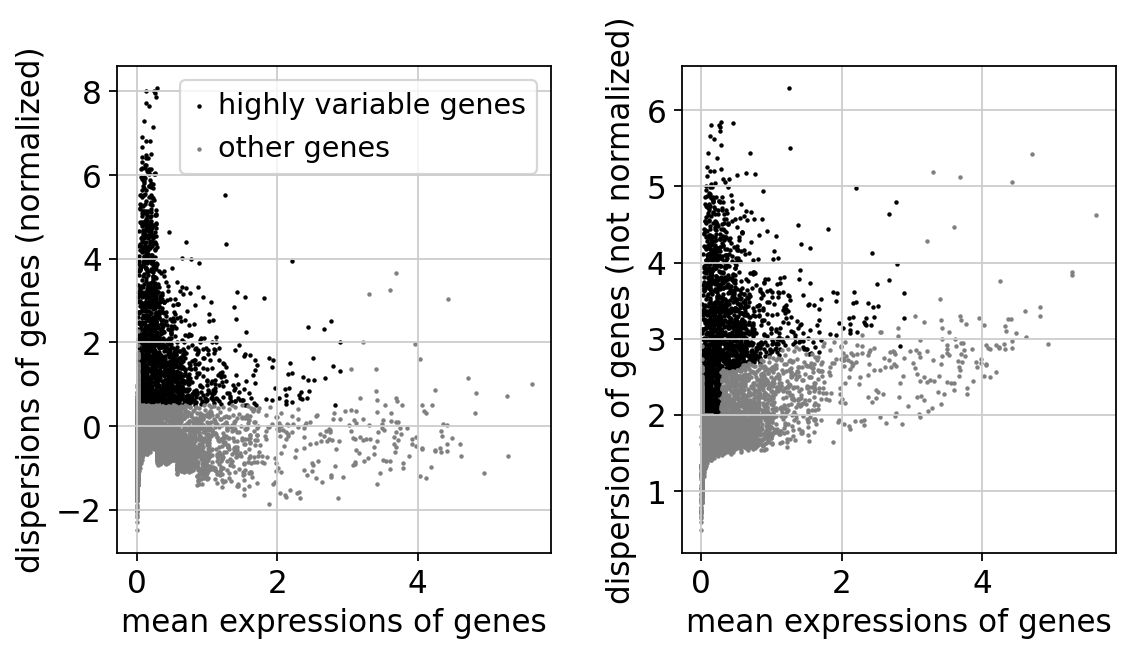

In [15]:
sc.pl.highly_variable_genes(adata)